In [11]:
from dask_jobqueue import HTCondorCluster
from dask.distributed import Client
import pde
import phasesep as ps
import numpy as np
from skimage.measure import label, regionprops
from skimage.filters import gaussian
import matplotlib.pyplot as plt

 ## Setting  up Dask cluster

In [2]:
cluster = HTCondorCluster(
    cores=8,
    memory="5GB",
    disk="10GB",
    processes=8,
    local_directory="$TMPDIR",
    log_directory="/home/ole.berendes/dasklogs",
    job_extra={"+MaxRunTime": 86400}
)

In [4]:
cluster.scale(1)
cluster


In [8]:
client = Client(cluster)


 ## Setting up the system

 ### Free energy density

In [8]:
f_scale = 1
f_slope = 0.02
f_offset = 0
kappa = 1
diffusive_mobility = 1
noise_diffusion = 2/30


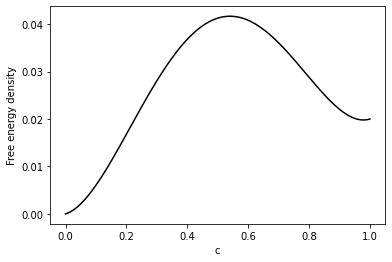

In [10]:

f = ps.GinzburgLandau2Components(
    prefactor=f_scale,
    slope=f_slope,
    offset=f_offset
)
f.plot()

In [11]:
binodal = f.get_binodal()[0][0]
spinodal = f.get_spinodal()[0]
binodal_range = spinodal - binodal


 ### Equation

In [16]:
eq = ps.CahnHilliardExtendedPDE(
    {
        "free_energy": f,
        "kappa": kappa,
        "mobility": diffusive_mobility,
        "noise_diffusion": noise_diffusion
    }
)
eq.cache_rhs = True


 ## Solve pde

 ### Define grid

In [17]:
nx, ny = 32, 32
x_start, x_end = -16, 16
y_start, y_end = -16, 16
grid = pde.CartesianGrid(
    bounds=[(x_start, x_end), (y_start, y_end)],
    shape=[nx,ny],
    periodic=True)


 ### Initial state

### Solve on dask cluster

0.04226497308103739


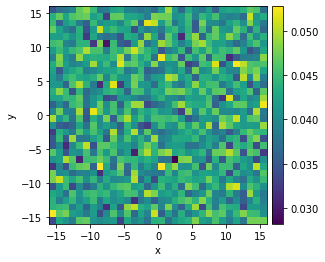

In [18]:
phi0 = binodal + 0.2*binodal_range

initial_field = pde.ScalarField.random_normal(
    grid=grid,
    mean=phi0,
    std=phi0*0.1
)
print(phi0)
initial_field.plot()

In [38]:
dt = 1e-3
def integrate(initial_state, t_end, dt=dt, eq=eq):
    storage = pde.MemoryStorage(field_obj=initial_state, write_mode="truncate_once")
    stor = storage.tracker()
    plot = pde.PlotTracker(interval=60, output_file="/home/ole.berendes/monitor.png")
    final = eq.solve(
        state=initial_state,
        t_range=t_end,
        tracker=[stor, plot],
        method="explicit",
        dt=dt
    )
    np.savez_compressed(
        "/home/ole.berendes/data/traj.npz",
        *storage.data
    )
    return final


In [39]:
future = client.submit(integrate, initial_field, 1e3)


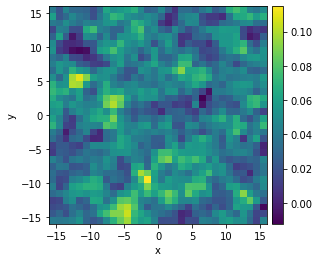

In [68]:
future.result().plot()

In [ ]:
from IPython.display import Image
Image(filename='/home/ole.berendes/monitor.png')

## Analysis

In [6]:
def calc_op(field):
    try:
        im = gaussian(field, sigma=2)
    except:
        im = gaussian(field.data, sigma=2)

    label_image = label(im > (np.mean(im) + 2 * np.std(im)))
    a = regionprops(label_image, im)

    N = np.zeros(len(a))
    i = 0
    for item in a:
        N[i] = item.mean_intensity
        i += 1
    try:
        return np.max(N)
    except:
        return 0

In [9]:
npz = np.load("/home/ole.berendes/data/traj.npz")

op_futures = []
for i in range(len(npz)):
    arr = npz[f"arr_{i}"]
    fut = client.submit(calc_op, arr)
    op_futures.append(fut)

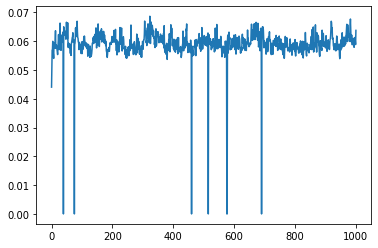

In [12]:
ops = client.gather(op_futures)
plt.plot(ops)

## Clean up

In [14]:
client.close()
cluster.close()
